In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from inspect import signature
from collections import namedtuple
import copy

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Utils

In [0]:
class Timer():
    def __init__(self):
        self.times = [time.time()]
        self.total_time = 0.0

    def __call__(self, include_in_total=True):
        self.times.append(time.time())
        dt = self.times[-1] - self.times[-2]
        if include_in_total:
            self.total_time += dt
        return dt

In [0]:
class TableLogger():
    def append(self, output):
        if not hasattr(self, 'keys'):
            self.keys = output.keys()
            print(*(f'{k:>12s}' for k in self.keys))
        filtered = [output[k] for k in self.keys]
        print(*(f'{v:12.4f}' if isinstance(v, np.float) else f'{v:12}' for v in filtered))

## data augmentation

In [0]:
class Cutout(namedtuple('Cutout', ('h', 'w'))):
    def __call__(self, x, x0, y0):
        x = copy.copy(x)
        x[:,y0:y0+self.h,x0:x0+self.w]
        return x

    def options(self, x_shape):
        C, H, W = x_shape
        return {'x0': range(W+1-self.w), 'y0': range(H+1-self.h)} 

In [0]:
class Transform():
    def __init__(self, dataset, transforms):
        self.dataset, self.transforms = dataset, transforms
        self.choices = None
        
    def __len__(self):
        return len(self.dataset)
           
    def __getitem__(self, index):
        data, labels = self.dataset[index]
        for choices, f in zip(self.choices, self.transforms):
            args = {k: v[index] for (k,v) in choices.items()}
            data = f(data, **args)
        return data, labels
    
    def set_random_choices(self):
        self.choices = []
        x_shape = self.dataset[0][0].shape
        N = len(self)
        for t in self.transforms:
            options = t.options(x_shape)
            x_shape = t.output_shape(x_shape) if hasattr(t, 'output_shape') else x_shape
            self.choices.append({k:np.random.choice(v, size=N) for (k,v) in options.items()})

## data loading

In [0]:
class Batches():
    def __init__(self, dataset, batch_size, shuffle, num_workers=0, drop_last=False):
        self.dataset = dataset
        self.dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle, drop_last=drop_last
        )
    
    def __iter__(self):  
        return ({'input': x.to(device).half(), 'target': y.to(device).long()} for (x,y) in self.dataloader)
    
    def __len__(self): 
        return len(self.dataloader)

## torch stuff

In [0]:
class Identity(nn.Module):
    def forward(self, x): return x
    
class Mul(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight
    def __call__(self, x): 
        return x*self.weight
    
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

class Add(nn.Module):
    def forward(self, x, y): return x + y 
    
class Concat(nn.Module):
    def forward(self, *xs): return torch.cat(xs, 1)
    
class Correct(nn.Module):
    def forward(self, classifier, target):
        return classifier.max(dim = 1)[1] == target

def batch_norm(num_channels, bn_bias_init=None, bn_bias_freeze=False, bn_weight_init=None, bn_weight_freeze=False):
    m = nn.BatchNorm2d(num_channels)
    if bn_bias_init is not None:
        m.bias.data.fill_(bn_bias_init)
    if bn_bias_freeze:
        m.bias.requires_grad = False
    if bn_weight_init is not None:
        m.weight.data.fill_(bn_weight_init)
    if bn_weight_freeze:
        m.weight.requires_grad = False
        
    return m

def to_numpy(x):
    return x.detach().cpu().numpy()

## dict utils

In [0]:
union = lambda *dicts: {k: v for d in dicts for (k, v) in d.items()}

def path_iter(nested_dict, pfx=()):
    for name, val in nested_dict.items():
        if isinstance(val, dict): yield from path_iter(val, (*pfx, name))
        else: yield ((*pfx, name), val)  

## graph building

In [0]:
sep='_'
RelativePath = namedtuple('RelativePath', ('parts'))
rel_path = lambda *parts: RelativePath(parts)

def build_graph(net):
    net = dict(path_iter(net)) 
    default_inputs = [[('input',)]]+[[k] for k in net.keys()]
    with_default_inputs = lambda vals: (val if isinstance(val, tuple) else (val, default_inputs[idx]) for idx,val in enumerate(vals))
    parts = lambda path, pfx: tuple(pfx) + path.parts if isinstance(path, RelativePath) else (path,) if isinstance(path, str) else path
    return {sep.join((*pfx, name)): (val, [sep.join(parts(x, pfx)) for x in inputs]) for (*pfx, name), (val, inputs) in zip(net.keys(), with_default_inputs(net.values()))}
    
class TorchGraph(nn.Module):
    def __init__(self, net):
        self.graph = build_graph(net)
        super().__init__()
        for n, (v, _) in self.graph.items(): 
            setattr(self, n, v)

    def forward(self, inputs):
        self.cache = dict(inputs)
        for n, (_, i) in self.graph.items():
            self.cache[n] = getattr(self, n)(*[self.cache[x] for x in i])
        return self.cache
    
    def half(self):
        for module in self.children():
            if type(module) is not nn.BatchNorm2d:
                module.half()    
        return self

## training utils

In [0]:
class PiecewiseLinear(namedtuple('PiecewiseLinear', ('knots', 'vals'))):
    def __call__(self, t):
        return np.interp([t], self.knots, self.vals)[0]

trainable_params = lambda model:filter(lambda p: p.requires_grad, model.parameters())

def nesterov(params, momentum, weight_decay=None):
    return torch.optim.SGD(params, lr=0.001, momentum=momentum, weight_decay=weight_decay, nesterov=True)

concat = lambda xs: np.array(xs) if xs[0].shape is () else np.concatenate(xs)

def set_opt_params(optimizer, params):
    for k, v in params.items():
        optimizer.param_groups[0][k] = v
    return optimizer

def update(model, optimizer):
    assert model.training
    model.cache['loss'].backward()
    optimizer.step()
    model.zero_grad()
    
def collect(stats, output):
    for k,v in stats.items():
        v.append(to_numpy(output[k]))

def train_epoch(model, batches, optimizer, lrs, stats):
    model.train(True)   
    for lr, batch in zip(lrs, batches):
        collect(stats, model(batch))
        update(model, set_opt_params(optimizer, {'lr': lr}))
    return stats

def test_epoch(model, batches, stats):
    model.train(False)
    for batch in batches:
        collect(stats, model(batch))
    return stats

In [0]:
sum_ = lambda xs: np.sum(concat(xs), dtype=np.float)

In [0]:
def train(model, lr_schedule, optimizer, train_set, test_set, batch_size=512, 
          loggers=(), test_time_in_total=True, num_workers=0, drop_last=False, timer=None):  
    t = timer or Timer()
    train_batches = Batches(train_set, batch_size, shuffle=True, num_workers=num_workers, drop_last=drop_last)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)
    N_train, N_test = len(train_set), len(test_set)
    if drop_last: N_train -= (N_train % batch_size)

    for epoch in range(lr_schedule.knots[-1]):
        train_batches.dataset.set_random_choices() 
        lrs = (lr_schedule(x)/batch_size for x in np.arange(epoch, epoch+1, 1/len(train_batches)))
        train_stats, train_time = train_epoch(model, train_batches, optimizer, lrs, {'loss': [], 'correct': []}), t()
        test_stats, test_time = test_epoch(model, test_batches, {'loss': [], 'correct': []}), t(test_time_in_total)
        
        arr_train_loss = np.array(train_stats['loss'])
        arr_test_loss = np.array(test_stats['loss'])

        filter_train_loss = []
        filter_test_loss = []

        for element in arr_train_loss:
          if element > 50:
            filter_train_loss.append(False)
          elif element < 0:
            filter_train_loss.append(False)
          else:
            filter_train_loss.append(True)
        
        for element in arr_test_loss:
          if element > 50:
            filter_test_loss.append(False)
          elif element < 0:
            filter_test_loss.append(False)
          else:
            filter_test_loss.append(True)

        new_train_loss = arr_train_loss[filter_train_loss]
        new_test_loss = arr_test_loss[filter_test_loss]
        summary = {
           'epoch': epoch+1, 
           'lr': lr_schedule(epoch+1), 
          #  'train time': train_time, 
           'train loss': sum_(new_train_loss)/N_train, 
           'train acc': sum_(train_stats['correct'])/N_train, 
          #  'test time': test_time, 
           'test loss': sum_(new_test_loss)/N_test, 
           'test acc': sum_(test_stats['correct'])/N_test,
           'total time': t.total_time, 
        }

        for logger in loggers:
            logger.append(summary)    
    return summary

#Train

##model

In [0]:
def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def residual(c, **kw):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c, **kw),
        'res2': conv_bn(c, c, **kw),
        'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')]),
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'classifier': {
            'pool': nn.MaxPool2d(4),
            'flatten': Flatten(),
            'linear': nn.Linear(channels['layer3'], 10, bias=False),
            'logits': Mul(weight),
        }
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), 
        res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n

losses = {
    'loss':  (nn.CrossEntropyLoss(reduction='sum'), [('classifier','logits'), ('target',)]),
    'correct': (Correct(), [('classifier','logits'), ('target',)]),
}

##dataset

In [119]:
from sklearn.model_selection import train_test_split
url = 'https://raw.githubusercontent.com/qinyudiao/data_science_lab/master/pokemon-classification/pokemon_img_43by43_types.csv'
data = pd.read_csv(url)
data

,Unnamed: 0,id,name,species,type1,type2,gen,p0000,p0001,p0002,p0003,p0004,p0005,p0006,p0007,p0008,p0009,p0010,p0011,p0012,p0013,p0014,p0015,p0016,p0017,p0018,p0019,p0020,p0021,p0022,p0023,p0024,p0025,p0026,p0027,p0028,p0029,p0030,p0031,p0032,...,p7374,p7375,p7376,p7377,p7378,p7379,p7380,p7381,p7382,p7383,p7384,p7385,p7386,p7387,p7388,p7389,p7390,p7391,p7392,p7393,p7394,p7395,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
0,0,1,Bulbasaur,Seed Pokemon,Grass,Poison,1,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,2,Ivysaur,Seed Pokemon,Grass,Poison,1,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,3,Venusaur,Seed Pokemon,Grass,Poison,1,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,4,Charmander,Lizard Pokemon,Fire,NaN,1,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,4,5,Charmeleon,Flame Pokemon,Fire,NaN,1,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,796,797,Celesteela,Launch Pokemon,Steel,Flying,7,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
797,797,798,Kartana,Drawn Sword Pokemon,Grass,Steel,7,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
798,798,799,Guzzlord,Junkivore Pokemon,Dark,Dragon,7,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
799,799,800,Necrozma,Prism Pokemon,Psychic,NaN,7,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,...,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


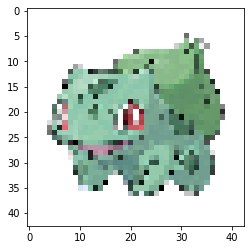

In [120]:
imgs = data.loc[:,"p0000":"p7395"]
imgs = imgs.values

for i in range(1):
    img = imgs[i]
    plt.figure()
    plt.imshow(img.reshape(43,43,4))

In [121]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
np.random.seed(50)
train_set = datasets.ImageFolder(r'/content/drive/My Drive/Colab Notebooks/datasets/Pokemons/train',transform=transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.6, 1.0)),
    # transforms.ColorJitter(brightness=5, contrast=5, saturation=5, hue=0.2),
    # transforms.RandomRotation((-20,20)),
    # transforms.RandomHorizontalFlip(p=0.7),
    # transforms.RandomVerticalFlip(p=0.7),
    transforms.ToTensor(),
    # transforms.Normalize((0.5494, 0.5418, 0.5247), (0.3938, 0.3922, 0.3920))
]))
test_set = datasets.ImageFolder(r'/content/drive/My Drive/Colab Notebooks/datasets/Pokemons/test',transform=transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.6, 1.0)),
    # transforms.RandomRotation((-20,20)),
    # transforms.RandomHorizontalFlip(p=0.7),
    # transforms.RandomVerticalFlip(p=0.7),
    # transforms.ColorJitter(brightness=5, contrast=5, saturation=5, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize((0.5639, 0.5592, 0.5497), (0.3903, 0.3884, 0.3865))
]))

In [0]:
np.random.seed(50)
train_set = datasets.ImageFolder(r'/content/drive/My Drive/Colab Notebooks/datasets/Pokemons/train_primary',
                                 transform=transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=5, contrast=5, saturation=5, hue=0.2),
    # transforms.RandomRotation((-20,20)),
    # transforms.RandomHorizontalFlip(p=0.7),
    # transforms.RandomVerticalFlip(p=0.7),
    transforms.ToTensor(),
    # transforms.Normalize((0.5834, 0.5749, 0.5650), (0.3754, 0.3728, 0.3752))
]))
test_set = datasets.ImageFolder(r'/content/drive/My Drive/Colab Notebooks/datasets/Pokemons/test_primary',
                                transform=transforms.Compose([                     
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    # transforms.RandomRotation((-20,20)),
    # transforms.RandomHorizontalFlip(p=0.7),
    # transforms.RandomVerticalFlip(p=0.7),
    # transforms.ColorJitter(brightness=5, contrast=5, saturation=5, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize((0.6159, 0.6079, 0.5968), (0.3715, 0.3672, 0.3699))
]))

## Calculate mean and std of the dataset

In [169]:
loader = torch.utils.data.DataLoader(test_set,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False)

mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
print(mean)
std /= len(loader.dataset)
print(std)

tensor([0.6113, 0.6029, 0.5916])
tensor([0.3714, 0.3667, 0.3695])


##train

In [177]:
lr_schedule = PiecewiseLinear([0, 5, 60], [0.006, 0.01, 0.006])
batch_size = 16
momentum = 0.8
weight_decay = 5e-4*batch_size

cutout=4

summaries = []
print('Starting Run')
model = TorchGraph(union(net(), losses)).to(device).half()
opt = nesterov(trainable_params(model), momentum=momentum, weight_decay=weight_decay)
# opt = torch.optim.Adam(trainable_params(model))
summaries.append(train(model, lr_schedule, opt, Transform(train_set, [Cutout(cutout, cutout)]), 
                       test_set, batch_size=batch_size, loggers=(TableLogger(),)))

Starting Run
       epoch           lr   train loss    train acc    test loss     test acc   total time
           1       0.0068       2.1113       0.2239       2.1552       0.1250       1.7921
           2       0.0076       1.8842       0.3127       1.7844       0.4167       3.6498
           3       0.0084       1.7946       0.3900       1.8826       0.4306       5.5092
           4       0.0092       1.6934       0.4208       1.8913       0.3750       7.3317
           5       0.0100       1.6189       0.4266       1.8797       0.3750       9.0968
           6       0.0099       1.5365       0.4672       1.8196       0.4306      10.8287
           7       0.0099       1.4184       0.5058       1.8344       0.3889      12.6347
           8       0.0098       1.3130       0.5560       1.8609       0.4028      14.4379
           9       0.0097       1.1794       0.6216       2.1860       0.3194      16.2753
          10       0.0096       1.0727       0.6602       1.9604       0.4028